In [30]:
import sys
sys.path.append('../')

In [31]:
from torchdyn.models import *
from torchdyn import *
from torchdyn.datasets import *

**Data:** we use again the moons dataset (with some added noise) simply because all the models will be effective to solve the binary classification problem.



In [32]:
d = ToyDataset()
X, yn = d.generate(n_samples=32, dataset_type='moons', noise=.4)

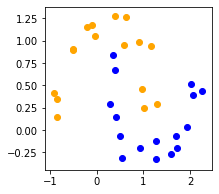

In [33]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], color=colors[yn[i].int()])

In [34]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

**Learner**

In [35]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module): #settings:dict={}):
        super().__init__()
        #defaults.update(settings)
        #self.settings = defaults
        self.model = model
        self.c = 0
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        y_hat = self.model(x)  
        loss = nn.CrossEntropyLoss()(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.005)

    def train_dataloader(self):
        return trainloader

In [36]:
from torch.autograd import grad as grad

In [37]:
import pdb
class intloss(nn.Module):
    def __init__(self, f):
        super().__init__()
        self.f = f
    def forward(self, x):
        #x.requires_grad_(True)
        loss = 1e-4*torch.abs(self.f(x)).sum(1) #grad(self.f(s, x), x, create_graph=True
        return loss

In [38]:
from torch.autograd.functional import jacobian as jac
class Stable2(nn.Module):
    """Stable Neural Flow"""
    def __init__(self, net, depthvar=False):
        super().__init__()
        self.net, self.depthvar = net, depthvar

    def forward(self, x):
        bs, n = x.shape[0], x.shape[1] // 2
        out = -jac(self.net, x.requires_grad_(True), create_graph=True)[range(bs), :, range(bs), :]
        return out[:,:-1] if self.depthvar else out

In [39]:
class Stable(nn.Module):
    """Stable Neural Flow"""
    def __init__(self, net, depthvar=False, controlled=False):
        super().__init__()
        self.net, self.depthvar, self.controlled = net, depthvar, controlled

    def forward(self, x):
        with torch.set_grad_enabled(True):
            bs, n = x.shape[0], x.shape[1] // 2
            x = x.requires_grad_(True)
            eps = self.net(x).sum()
            out = -torch.autograd.grad(eps, x, allow_unused=False, create_graph=True)[0] 
            #self.out = out
        out = out[:,:-1] if self.depthvar else out
        out = out[:,:-2] if self.controlled else out
        return out

In [40]:
# vector field parametrized by a NN
f = Stable(nn.Sequential(
                  nn.Linear(2, 64),
                  nn.Tanh(), 
                  nn.Linear(64, 1)))
                  

# neural ODE
model = NeuralDE(f, 
                 order=1,
                 solver='dopri5', 
                 sensitivity='adjoint', 
                 controlled=False,
                 intloss=intloss(f)).to(device)
seq = nn.Sequential(model)

In [41]:
# boh = DEFunc(f, order=1, controlled=False)

# x = torch.randn(10, 2, requires_grad=False)

# x = x.requires_grad_(True)

# b = boh( torch.zeros(1),x.cuda(),)
# torch.autograd.grad(b.sum(), x)

# train the neural ODE
learn = Learner(seq)
trainer = pl.Trainer(min_nb_epochs=300, max_nb_epochs=600)
trainer.fit(learn)

INFO:lightning:
  | Name                   | Type       | Params
--------------------------------------------------
0 | model                  | Sequential | 257   
1 | model.0                | NeuralDE   | 257   
2 | model.0.defunc         | DEFunc     | 257   
3 | model.0.defunc.m       | Stable     | 257   
4 | model.0.defunc.m.net   | Sequential | 257   
5 | model.0.defunc.m.net.0 | Linear     | 192   
6 | model.0.defunc.m.net.1 | Tanh       | 0     
7 | model.0.defunc.m.net.2 | Linear     | 65    
8 | model.0.intloss        | intloss    | 257   
9 | model.0.adjoint        | Adjoint    | 257   


1

**Plots**

In [53]:
# Evaluate the data trajectories
s_span = torch.linspace(0,5,100)
X_d = seq[0](X_train)
trajectory = model.trajectory(X_d, s_span).detach().cpu()

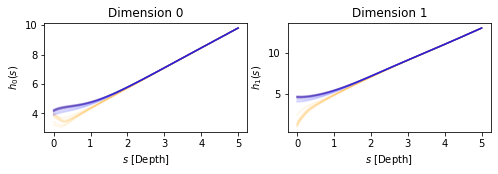

In [54]:
# Trajectories in the depth domain
plot_2D_depth_trajectory(s_span, trajectory, yn, len(X))